
### This is notebook shows how we can use spark RDDs to manipulate, filter out and operate on datasets that contain a lot of information, in a user friendly manner. I have pulled the data of 5 Stock tickers: Amazon, Meta, PepsiCo,Nvidia and Tesla from 2013 to 2021 and stored it in a text file. The operations that have been performed are described at each step. The text file does not contain headers but the attributes of this dataset are Stock,Date,Open,High,Low,Close,Volume.

### -> Initializing spark and reading data

In [1]:
from pyspark import SparkContext

sc = SparkContext("local[4]", "Stocks")

22/11/06 23:25:48 WARN Utils: Your hostname, Pramits-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.0.0.72 instead (on interface en0)
22/11/06 23:25:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/06 23:25:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
stocksFile = sc.textFile("Stocks.txt")
stocksFile

Stocks.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [3]:
stocksFile.take(4)

['AMZN,2013-01-02,12.87,12.9,12.66,12.8,65420000',
 'AMZN,2013-01-03,12.92,13.04,12.82,12.86,55018000',
 'AMZN,2013-01-04,12.96,12.99,12.83,12.88,37484000',
 'AMZN,2013-01-07,13.42,13.49,13.13,13.15,98200000']

Tokenizing each line

In [4]:
Tok = stocksFile.map(lambda n: n.split(','))
Tok.take(5)

[['AMZN', '2013-01-02', '12.87', '12.9', '12.66', '12.8', '65420000'],
 ['AMZN', '2013-01-03', '12.92', '13.04', '12.82', '12.86', '55018000'],
 ['AMZN', '2013-01-04', '12.96', '12.99', '12.83', '12.88', '37484000'],
 ['AMZN', '2013-01-07', '13.42', '13.49', '13.13', '13.15', '98200000'],
 ['AMZN', '2013-01-08', '13.32', '13.45', '13.18', '13.35', '60214000']]

Converting to the right data types


In [5]:
Tok_Conv = Tok.map(lambda n:[n[0], n[1], float(n[2]), float(n[3]), float(n[4]), float(n[5]), int(n[6])])
Tok_Conv.take(5)

[['AMZN', '2013-01-02', 12.87, 12.9, 12.66, 12.8, 65420000],
 ['AMZN', '2013-01-03', 12.92, 13.04, 12.82, 12.86, 55018000],
 ['AMZN', '2013-01-04', 12.96, 12.99, 12.83, 12.88, 37484000],
 ['AMZN', '2013-01-07', 13.42, 13.49, 13.13, 13.15, 98200000],
 ['AMZN', '2013-01-08', 13.32, 13.45, 13.18, 13.35, 60214000]]

### -> Exploring the data
Checking total Entries

In [6]:
TotalCount = stocksFile.count()
TotalCount

11325

Entries per stock

In [7]:
EntriesPerStock = Tok.countByKey()
EntriesPerStock                                    

defaultdict(int,
            {'AMZN': 2265,
             'META': 2265,
             'NVDA': 2265,
             'PEP': 2265,
             'TSLA': 2265})

Mapping every stock entry to its volume

In [8]:
RDD_Vol = Tok_Conv.map(lambda n: (n[0], n[6]))
RDD_Vol.take(2)

[('AMZN', 65420000), ('AMZN', 55018000)]

Checking the net volume per stock

In [9]:
Vol_Per_Stock = RDD_Vol.reduceByKey(lambda n,m : n+m)
Vol_Per_Stock.collect()

[('PEP', 10546399700),
 ('AMZN', 182903438000),
 ('META', 65984997400),
 ('NVDA', 98691508000),
 ('TSLA', 260349513600)]

Sorting based on max volume


In [11]:
Sorted_By_Vol = Vol_Per_Stock.sortBy(lambda n: n[1], ascending = False)
Sorted_Vol = Sorted_By_Vol.collect()
print(Sorted_Vol)

[('TSLA', 260349513600), ('AMZN', 182903438000), ('NVDA', 98691508000), ('META', 65984997400), ('PEP', 10546399700)]


<BarContainer object of 5 artists>

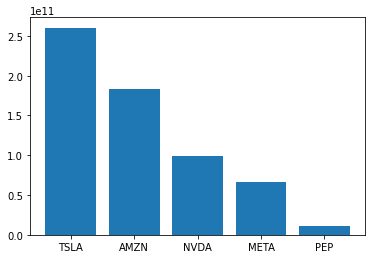

In [12]:
import matplotlib.pyplot as plt
TickerList = list()
VolList = list()
for Ticker,Volume in Sorted_Vol:
    TickerList.append(Ticker)
    VolList.append(Volume)
plt.bar(TickerList,VolList)

Creating a new RDD with the highest and lowest values for each stock every day, and the respective dates

In [14]:
High_Low = Tok_Conv.map(lambda n: (n[0], [(n[3],n[1]),(n[4],n[1])]))
High_Low.take(5)

[('AMZN', [(12.9, '2013-01-02'), (12.66, '2013-01-02')]),
 ('AMZN', [(13.04, '2013-01-03'), (12.82, '2013-01-03')]),
 ('AMZN', [(12.99, '2013-01-04'), (12.83, '2013-01-04')]),
 ('AMZN', [(13.49, '2013-01-07'), (13.13, '2013-01-07')]),
 ('AMZN', [(13.45, '2013-01-08'), (13.18, '2013-01-08')])]

Checking the dates for the best and the worst performance

In [16]:
Dates_High_Low = High_Low.reduceByKey(lambda n,m : (max(n[0],m[0]), min(n[1],m[1])))
sorted(Dates_High_Low.collect())

[('AMZN', ((188.65, '2021-07-13'), (12.29, '2013-05-01'))),
 ('META', ((384.33, '2021-09-01'), (22.67, '2013-06-06'))),
 ('NVDA', ((346.19, '2021-11-22'), (2.75, '2013-01-15'))),
 ('PEP', ((170.09, '2021-12-16'), (51.82, '2013-01-02'))),
 ('TSLA', ((414.5, '2021-11-04'), (2.14, '2013-01-11')))]

Modifying every entry to show the (ticker, year) and the volume



In [17]:
Tick_Yr_Vol = Tok_Conv.map(lambda n: ((n[0],n[1].split("-")[0]), int(n[6])))
Tick_Yr_Vol.take(5)

[(('AMZN', '2013'), 65420000),
 (('AMZN', '2013'), 55018000),
 (('AMZN', '2013'), 37484000),
 (('AMZN', '2013'), 98200000),
 (('AMZN', '2013'), 60214000)]

Showing the volume per year for every stock in alphabetical order

In [18]:
Vol_Per_Year = Tick_Yr_Vol.reduceByKey(lambda n,m : n+m)
sorted(Vol_Per_Year.collect())

[(('AMZN', '2013'), 14958114000),
 (('AMZN', '2014'), 20581334000),
 (('AMZN', '2015'), 19142040000),
 (('AMZN', '2016'), 20775126000),
 (('AMZN', '2017'), 17654108000),
 (('AMZN', '2018'), 28357952000),
 (('AMZN', '2019'), 19493002000),
 (('AMZN', '2020'), 24950814000),
 (('AMZN', '2021'), 16990948000),
 (('META', '2013'), 15143182600),
 (('META', '2014'), 11977699100),
 (('META', '2015'), 6793637600),
 (('META', '2016'), 6419717900),
 (('META', '2017'), 4214278100),
 (('META', '2018'), 6942307800),
 (('META', '2019'), 4083979700),
 (('META', '2020'), 5678912800),
 (('META', '2021'), 4731281800),
 (('NVDA', '2013'), 8914737600),
 (('NVDA', '2014'), 7155693600),
 (('NVDA', '2015'), 7818756400),
 (('NVDA', '2016'), 11159860400),
 (('NVDA', '2017'), 17215246800),
 (('NVDA', '2018'), 13756960800),
 (('NVDA', '2019'), 11501271600),
 (('NVDA', '2020'), 12165638000),
 (('NVDA', '2021'), 9003342800),
 (('PEP', '2013'), 1265822500),
 (('PEP', '2014'), 1205936600),
 (('PEP', '2015'), 1193118000

### Plotting Amazon and Tesla Volume over the years

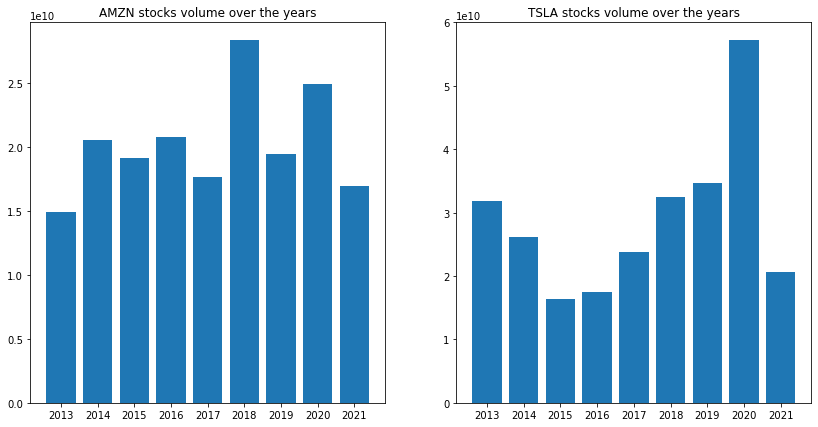

In [19]:
YearlistAMZN,YearlistTSLA = list(),list()
VolListAMZN,VolListTSLA = list(),list()
for (Ticker,Year),Volume in sorted(Vol_Per_Year.collect()):
    if Ticker == 'AMZN':
        YearlistAMZN.append(Year)
        VolListAMZN.append(Volume)
    if Ticker == 'TSLA':
        YearlistTSLA.append(Year)
        VolListTSLA.append(Volume)
plt.figure(figsize =(14,7))
plt.subplot(1, 2, 1)
plt.bar(YearlistAMZN,VolListAMZN)
plt.title('AMZN stocks volume over the years')

plt.subplot(1, 2, 2)
plt.bar(YearlistTSLA,VolListTSLA)
plt.title('TSLA stocks volume over the years')

plt.show()

### Best and worst performance per year, shown with the exact date for every stock

In [20]:
sorted(Tok_Conv.map(lambda n: ((n[0], n[1][:4]), ((n[3], n[1]), (n[4], n[1])))).reduceByKey(lambda n, m: (max(n[0], m[0]), min(n[1], m[1]))).collect())

[(('AMZN', '2013'), ((20.28, '2013-12-27'), (12.29, '2013-05-01'))),
 (('AMZN', '2014'), ((20.4, '2014-01-22'), (14.2, '2014-10-24'))),
 (('AMZN', '2015'), ((34.82, '2015-12-29'), (14.26, '2015-01-16'))),
 (('AMZN', '2016'), ((42.36, '2016-10-06'), (23.7, '2016-02-09'))),
 (('AMZN', '2017'), ((60.67, '2017-11-27'), (37.38, '2017-01-03'))),
 (('AMZN', '2018'), ((102.53, '2018-09-04'), (58.53, '2018-01-02'))),
 (('AMZN', '2019'), ((101.79, '2019-07-11'), (73.05, '2019-01-02'))),
 (('AMZN', '2020'), ((177.61, '2020-09-02'), (81.3, '2020-03-16'))),
 (('AMZN', '2021'), ((188.65, '2021-07-13'), (144.05, '2021-03-05'))),
 (('META', '2013'), ((58.58, '2013-12-24'), (22.67, '2013-06-06'))),
 (('META', '2014'), ((82.17, '2014-12-23'), (51.85, '2014-01-27'))),
 (('META', '2015'), ((110.65, '2015-11-05'), (72.0, '2015-08-24'))),
 (('META', '2016'), ((133.5, '2016-10-25'), (89.37, '2016-01-20'))),
 (('META', '2017'), ((184.25, '2017-11-28'), (115.51, '2017-01-03'))),
 (('META', '2018'), ((218.62, '

### Comparitive analysis between Tesla and Amazon 
Filtering for Tesla and getting the results in a new RDD with the Date, Open and close information, and adding the percentage change every day

In [21]:
RDD_TSLA = Tok_Conv.filter(lambda n : n[0] == "TSLA")
RDD_TSLA = RDD_TSLA.map(lambda n : (n[1],[n[0],n[2],n[5], round((n[5]-n[2])/n[2]*100,2)]))
RDD_TSLA.take(4)

[('2013-01-02', ['TSLA', 2.36, 2.33, -1.27]),
 ('2013-01-03', ['TSLA', 2.32, 2.35, 1.29]),
 ('2013-01-04', ['TSLA', 2.29, 2.32, 1.31]),
 ('2013-01-07', ['TSLA', 2.29, 2.32, 1.31])]

Repeating the previous step for Amazon stocks

In [22]:
RDD_AMZN = Tok_Conv.filter(lambda n : n[0] == "AMZN")
RDD_AMZN = RDD_AMZN.map(lambda n : (n[1],[n[0],n[2],n[5], round((n[5]-n[2])/n[2]*100,2)]))
RDD_AMZN.take(4)

[('2013-01-02', ['AMZN', 12.87, 12.8, -0.54]),
 ('2013-01-03', ['AMZN', 12.92, 12.86, -0.46]),
 ('2013-01-04', ['AMZN', 12.96, 12.88, -0.62]),
 ('2013-01-07', ['AMZN', 13.42, 13.15, -2.01])]

Joining the results from the previous 2 steps


In [23]:
Joined_TSLA_AMZN = RDD_TSLA.fullOuterJoin(RDD_AMZN)
Joined_TSLA_AMZN.takeOrdered(4)

[('2013-01-02', (['TSLA', 2.36, 2.33, -1.27], ['AMZN', 12.87, 12.8, -0.54])),
 ('2013-01-03', (['TSLA', 2.32, 2.35, 1.29], ['AMZN', 12.92, 12.86, -0.46])),
 ('2013-01-04', (['TSLA', 2.29, 2.32, 1.31], ['AMZN', 12.96, 12.88, -0.62])),
 ('2013-01-07', (['TSLA', 2.29, 2.32, 1.31], ['AMZN', 13.42, 13.15, -2.01]))]

Filtering the results to show which stock performed better each day


In [24]:
Best_Performing = Joined_TSLA_AMZN.mapValues(lambda n : n[0] if n[0][3] > n[1][3] else n[1])
Best_Performing.takeOrdered(10)

[('2013-01-02', ['AMZN', 12.87, 12.8, -0.54]),
 ('2013-01-03', ['TSLA', 2.32, 2.35, 1.29]),
 ('2013-01-04', ['TSLA', 2.29, 2.32, 1.31]),
 ('2013-01-07', ['TSLA', 2.29, 2.32, 1.31]),
 ('2013-01-08', ['TSLA', 2.25, 2.3, 2.22]),
 ('2013-01-09', ['TSLA', 2.24, 2.27, 1.34]),
 ('2013-01-10', ['AMZN', 13.27, 13.43, 1.21]),
 ('2013-01-11', ['TSLA', 2.19, 2.27, 3.65]),
 ('2013-01-14', ['TSLA', 2.22, 2.21, -0.45]),
 ('2013-01-15', ['AMZN', 13.6, 13.53, -0.51])]